# Training ESM on 

In [81]:
import os
from tqdm import tqdm
import pickle as pkl
import glob
import random
random.seed(0)

import ete3

import pandas as pd
import numpy as np
np.random.seed(0)

from scipy.stats import pearsonr
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics  import mean_squared_error, r2_score, root_mean_squared_error, median_absolute_error

import umap
import Levenshtein

import torch
torch.manual_seed(0)
torch.use_deterministic_algorithms(False)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics import R2Score


import matplotlib.pyplot as plt
import seaborn as sns

# Creat train test set


In [ ]:
# Cluster all fastas at 30 % 
! for DIR in `ls`; do  mmseqs easy-cluster ${DIR}/fasta.v11.5.${DIR}.fa ${DIR}/clu_30 tmp --min-seq-id 0.3 -c 0.8 --cov-mode 1; done

#create train test split from clusters
! for DIR in `ls`; do if [ -f ${DIR}/clu_30_cluster.tsv ]; then N_CLU=$(cat ${DIR}/clu_30_cluster.tsv | cut -f 1 | uniq -c | sort -n -r | cut -f 7,8 -d " " | wc -l) ; N_TEST=$(($N_CLU/5)); N_TRAIN=$((${N_CLU}-${N_TEST})); cat ${DIR}/clu_30_cluster.tsv | cut -f 1 | uniq -c | sort -n -r | tail -n ${N_TEST} | awk ' { t = $1; $1 = $2; $2 = t; print; } ' > ${DIR}/test.fa ; cat ${DIR}/clu_30_cluster.tsv | cut -f 1 | uniq -c | sort -n -r | head -n ${N_TRAIN} | awk ' { t = $1; $1 = $2; $2 = t; print; } ' > ${DIR}/train.fa;  fi ; done  

In [82]:

data_split_dir = "../../data/PaxDb/Paxdb-sequences_processed/"

embedding_files = glob.glob("../../data/PaxDb/Paxdb-embedding/*")
dfs = {}
organisms = []
for file in embedding_files:
    if file[-3:] != "pkl":
        continue
        
    with open(file, "br") as f:
        organism = file.split("/")[-1].split("_")[0]

        training_partition_file = f"{data_split_dir}/{organism}/train.fa"
        training_ids = pd.read_csv(training_partition_file, sep=" ", names=["id", "count"])
        training_ids = training_ids["id"].to_list()
        
        test_partition_file = f"{data_split_dir}/{organism}/train.fa"
        test_ids = pd.read_csv(test_partition_file, sep=" ", names=["id", "count"])
        test_ids = test_ids["id"].to_list()

        print(f"Appending file {file}")
        tmp_df = pkl.load(f)
        if len(tmp_df['id']) < 10:
            print(f"File: {file} does not have enoghe entries with: {len(tmp_df['id'])} entries")
            continue
            
        tmp_df["Embedding"] = tmp_df["Embedding"][:len(tmp_df["id"])] # Make sure to remove last two copys of embeddings  ( bug from embedings calc script)
        
        dfs[organism] = {"id": tmp_df["id"],
                         "seq": tmp_df["seq"],
                         "abundance": tmp_df["TM"],
                         "Embeddings":tmp_df["Embedding"]}


            X_train, X_test, y_train, y_test = train_test_split(tmp_df["Embedding"].to_list(), tmp_df["TM"].to_list(), test_size=0.2, random_state=42)
            id_train, id_test, seq_train, seq_test = train_test_split(tmp_df["id"].to_list(), tmp_df["seq"].to_list(), test_size=0.2, random_state=42)
        else:
            X_train, X_test, y_train, y_test = train_test_split(tmp_df["Embedding"], tmp_df["TM"], test_size=0.2, random_state=42)
            id_train, id_test, seq_train, seq_test = train_test_split(tmp_df["id"], tmp_df["seq"], test_size=0.2, random_state=42)

        

        miss = check_test_split(seq_train, seq_test)
        if len(miss) > 0:
            print(f"Testset of organism: {organism} not independent have: {len(miss)} sequences with less than 5% difference to training set sequences\n Poping Overlapping sequences from test set")
            miss.sort(reverse=True)
            for m in miss:
                y_test.pop(m)
            for m in miss:
                X_test.pop(m)
        y_train_transform, lam = boxcox(y_train)
        y_test_transform       = boxcox(y_test, lam)
        
        dfs[organism]["lambda"] = lam
        dfs[organism]["train"] = list(zip(X_train,y_train_transform.astype(np.float32)))
        dfs[organism]["test"] = list(zip(X_test,y_test_transform.astype(np.float32)))
        dfs[organism]["test_labels"] = y_test
        dfs[organism]["train_labels"] = y_train
        dfs[organism]["Name"] = organism_dict[organism]


IndentationError: unexpected indent (769066925.py, line 35)

In [83]:
with open("../../data/PaxDb/Paxdb-sequences_processed/9606/training_df.pkl", "br") as f:
    df_tmp = pkl.load(f)
#training_ids = training_ids["id"].to_list()

<Axes: ylabel='Count'>

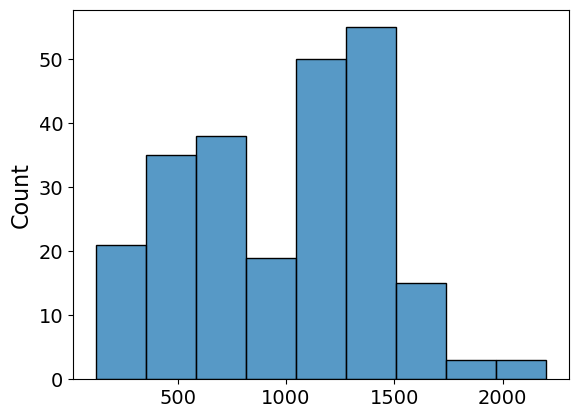

In [84]:
ss = []
for s in df_tmp['train_stat']['Test_experiment_Eval']:
    ss.append(len(s))
sns.histplot(ss)

In [85]:
import pickle as pkl
ncbi = ete3.NCBITaxa()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

Domain2TaxID = {"Eukaryota":2759, "Bacteria":2,"Archaea":2157}
TaxID2Domain = {2759:"Eukaryota", 2:"Bacteria", 2157:"Archaea"}
DOMAIN = {"Eukaryota", "Bacteria","Archaea"}

def get_domain(taxon_id):
    if taxon_id == "ho2018": 
        return "Eukaryota"
    lineage = ncbi.get_lineage(taxon_id)
    taxon_df = ncbi.get_taxid_translator(lineage)
    domain = [rec[1] for rec in taxon_df.items() if rec[1]  in DOMAIN  ]
    if len(domain) == 0:
        return "Ailian"
    else:
        return domain[0]


def calc_R2(true, pred, lam = None, log=False):
    true = true.numpy()
    pred = pred.detach().numpy().reshape(-1)

    if lam != None:
        pred = inv_boxcox(pred, lam)
        true = inv_boxcox(true, lam)
    
    if log:
        true=np.log10(true)
        pred=np.log10(pred)

    score = r2_score(true, pred)
    
    return score

def calc_RMSE(true, pred, lam = None, log=False):
    true = true.numpy()
    pred = pred.detach().numpy().reshape(-1)

    if lam != None:
        pred = inv_boxcox(pred, lam)
        true = inv_boxcox(true, lam)
    
    if log:
        true=np.log10(true)
        pred=np.log10(pred)

    score = root_mean_squared_error(true, pred)
    
    return score

files = glob.glob("../../data/PaxDb/Paxdb-sequences_processed/*/training_df_0.pkl")



df = {"Tax_id": [], "Domain":[], "Type":[], "R2":[], "R2_log10":[], "R2_BoxCox":[], "RMSE":[], "RMSE_log10":[],"RMSE_BoxCox":[]}

for file in tqdm(files):
    taxon_id = file.split("/")[-2]
    with open(file, "br") as f:
        df_tmp = pkl.load(f)
    domain = get_domain(taxon_id)
    # Add median valuse
    df["Tax_id"].append(taxon_id)
    df["Domain"].append(get_domain(taxon_id))
    df["Type"].append("Median")
    true = df_tmp['train_stat']['Test_True']
    pred = df_tmp['train_stat']['Test_Eval']
    df["R2"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=False))
    df["R2_BoxCox"].append(calc_R2(true, pred, lam = None, log=False))
    df["R2_log10"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=True))
    df["RMSE"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=False))
    df["RMSE_BoxCox"].append(calc_RMSE(true, pred, lam = None, log=False))
    df["RMSE_log10"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=True))

    # Add experiment values
    if len(df_tmp['train_stat']['Test_experiment_True']) > 0:

        for true, pred in zip(df_tmp['train_stat']['Test_experiment_True'], df_tmp['train_stat']['Test_experiment_Eval']):
            df["Tax_id"].append(taxon_id)
            df["Domain"].append(get_domain(taxon_id))
            df["Type"].append("Experiment")
            df["R2"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=False))
            df["R2_BoxCox"].append(calc_R2(true, pred, lam = None, log=False))
            df["R2_log10"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=True))
            df["RMSE"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=False))
            df["RMSE_BoxCox"].append(calc_RMSE(true, pred, lam = None, log=False))
            df["RMSE_log10"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=True))
df = pd.DataFrame(df)



# add all field
df_all_tmp = df.assign(Domain=df["Domain"].map(lambda x: "All"))
df = pd.concat([df, df_all_tmp])
df = df.assign(R2_BoxCox=df["R2_BoxCox"].map(lambda x: max(0,x)))
df = df.assign(R2_log10=df["R2_log10"].map(lambda x: max(0,x)))
df = df.assign(R2=df["R2"].map(lambda x: max(0,x)))

 66%|██████████████████████████████████████████████████████████████████████████▉                                       | 92/140 [00:24<00:09,  4.96it/s]/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 263820 was translated into 1122961
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/x_sanvi/.conda/envs/jupyter/lib/python3.12/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 263820 was translated into 1122961
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:36<00:00,  3.85it/s]


In [86]:
df_tmp = df.loc[df["Type"]=="Median"]
df_tmp.loc[df_tmp["Domain"] == "All"]["R2_BoxCox"].median() 

0.4383082985877991

In [89]:
df_tmp

,Tax_id,Domain,Type,R2,R2_log10,R2_BoxCox,RMSE,RMSE_log10,RMSE_BoxCox
0,5811,Eukaryota,Median,0.052276,0.449511,0.446661,1688.531494,0.724220,1.615628
2,122586,Bacteria,Median,0.000000,0.045559,0.062420,9462.662109,0.526481,0.575632
3,349741,Bacteria,Median,0.000000,0.558888,0.554815,2331.011719,0.553278,1.115139
5,5476,Eukaryota,Median,0.000000,0.618450,0.611320,2189.977051,0.607237,1.204455
7,10090,Eukaryota,Median,0.117005,0.438265,0.490604,172.830063,0.782386,1.840816
...,...,...,...,...,...,...,...,...,...
928,190192,All,Median,0.603533,0.421127,0.413170,2060.030762,0.586118,1.213870
930,30732,All,Median,0.000000,0.501958,0.494520,547.278076,0.618748,1.298279
932,768679,All,Median,0.015454,0.111849,0.107086,2955.589355,0.591248,0.944068
933,272559,All,Median,0.000000,0.516343,0.503136,2298.427979,0.616008,1.176349


In [155]:
df_pairwise_corr = pd.read_csv("/proj/berzelius-2024-205/sandra/DeepTranslation/result/2024-1001/pairwise_corr.csv", names=["idx_or_whatever", "Tax_id", "avg", "median", "N experiments"], header=1)
df_pair_corr_r2 = df_tmp.loc[df_tmp["Domain"] == "All"].merge(df_pairwise_corr, on = "Tax_id")
#df_pair_corr_r2 = df_pair_corr_r2.loc[df_pair_corr_r2["R2_BoxCox"]<0.4]


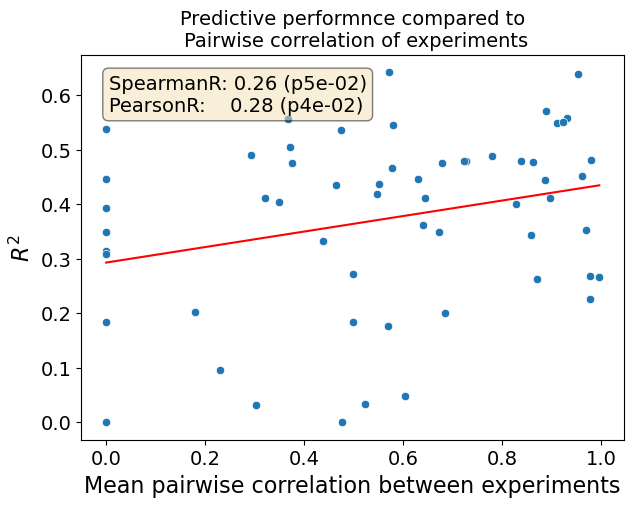

In [164]:
from sklearn.linear_model import LinearRegression
f, ax = plt.subplots(1, figsize=[7,5])
sns.scatterplot(data=df_pair_corr_r2, x= "avg", y="R2_BoxCox", ax=ax)
corr_p, s_p = pearsonr(df_pair_corr_r2["R2_BoxCox"], df_pair_corr_r2['avg'])
corr_s, s_s = spearmanr(df_pair_corr_r2['R2_BoxCox'], df_pair_corr_r2['avg'])

perf=df_pair_corr_r2["R2_BoxCox"].values
corr = df_pair_corr_r2['avg'].values

model = LinearRegression()

model.fit(corr.reshape(-1, 1), perf.reshape(-1, 1))
x = model.predict(np.array([min(corr),max(corr)]).reshape(-1, 1))


textstr = '\n'.join((
    r'SpearmanR: %.2f (p%.e)' % (corr_s, s_s),
    r'PearsonR:    %.2f (p%.e)' % (corr_p, s_p),))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.plot( np.array([min(corr),max(corr)]).reshape(-1, 1), x, c="r")

ax.set_ylabel(r"$R^2$")
ax.set_xlabel("Mean pairwise correlation between experiments")
ax.set_title("Predictive performnce compared to\n Pairwise correlation of experiments")
plt.savefig("/proj/berzelius-2024-205/sandra/DeepTranslation/result/2024-1001/pairwise_correlation_mean_vs_R2.pdf", bbox_inches="tight")

[[0.14298444]]


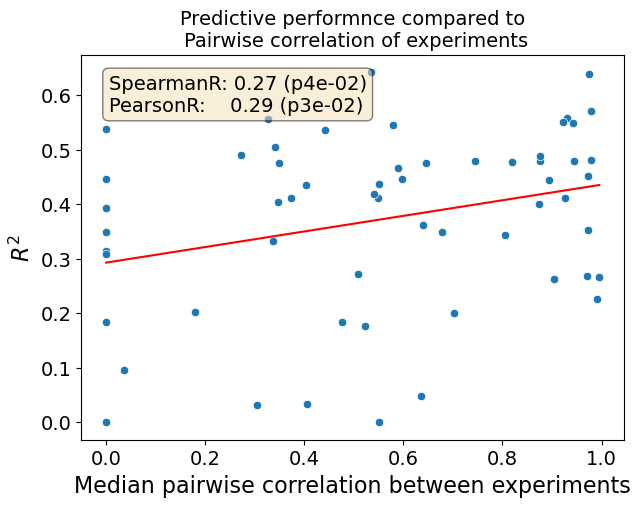

In [167]:
f, ax = plt.subplots(1, figsize=[7,5])
sns.scatterplot(data=df_pair_corr_r2, x= "median", y="R2_BoxCox", ax=ax)
#corr_p, s_p = pearsonr(df_pair_corr_r2["R2_BoxCox"], df_pair_corr_r2['avg'])
#corr_s, s_s = spearmanr(df_pair_corr_r2['R2_BoxCox'], df_pair_corr_r2['avg'])

corr_p, s_p = pearsonr(df_pair_corr_r2["median"], df_pair_corr_r2['R2_BoxCox'])
corr_s, s_s = spearmanr(df_pair_corr_r2['median'], df_pair_corr_r2['R2_BoxCox'])

perf=df_pair_corr_r2["R2_BoxCox"].values
corr = df_pair_corr_r2['median'].values

model = LinearRegression()

model.fit(corr.reshape(-1, 1), perf.reshape(-1, 1))
x = model.predict(np.array([min(corr),max(corr)]).reshape(-1, 1))

print(model.coef_)
textstr = '\n'.join((
    r'SpearmanR: %.2f (p%.e)' % (corr_s, s_s),
    r'PearsonR:    %.2f (p%.e)' % (corr_p, s_p),))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.plot( np.array([min(corr),max(corr)]).reshape(-1, 1), x, c="r")

ax.set_ylabel(r"$R^2$")
ax.set_xlabel("Median pairwise correlation between experiments")
ax.set_title("Predictive performnce compared to\n Pairwise correlation of experiments")
plt.savefig("/proj/berzelius-2024-205/sandra/DeepTranslation/result/2024-1001/pairwise_correlation_median_vs_R2.pdf", bbox_inches="tight")

In [78]:
df_tmp = df.loc[df["Type"]=="Median"]
df_tmp = df_tmp.loc[df_tmp["Domain"] == "All"]
df_tmp.loc[df_tmp["R2_BoxCox"]>0.5].shape


(39, 10)

In [80]:
df["Tax_id"].unique().shape

(140,)

In [129]:
df_pair_corr_r2.shape

(58, 13)

In [76]:
df

,Tax_id,Domain,Type,R2,R2_log10,R2_BoxCox,RMSE,RMSE_log10,RMSE_BoxCox,Name
0,5811,Eukaryota,Median,0.052276,0.449511,0.446661,1688.531494,0.724220,1.615628,T. gondii (5811)
1,5811,Eukaryota,Experiment,0.052276,0.449511,0.446661,1688.531494,0.724220,1.615628,T. gondii (5811)
2,122586,Bacteria,Median,0.000000,0.045559,0.062420,9462.662109,0.526481,0.575632,N. meningitidis (122586)
3,349741,Bacteria,Median,0.000000,0.558888,0.554815,2331.011719,0.553278,1.115139,A. muciniphila (349741)
4,349741,Bacteria,Experiment,0.000000,0.558888,0.554815,2331.011719,0.553278,1.115139,A. muciniphila (349741)
...,...,...,...,...,...,...,...,...,...,...
932,768679,All,Median,0.015454,0.111849,0.107086,2955.589355,0.591248,0.944068,T. tenax (768679)
933,272559,All,Median,0.000000,0.516343,0.503136,2298.427979,0.616008,1.176349,B. fragilis (272559)
934,272559,All,Experiment,0.000000,0.516343,0.503136,2298.427979,0.616008,1.176349,B. fragilis (272559)
935,709991,All,Median,0.000000,0.492309,0.477577,3978.612061,0.604834,1.158990,O. splanchnicus (709991)


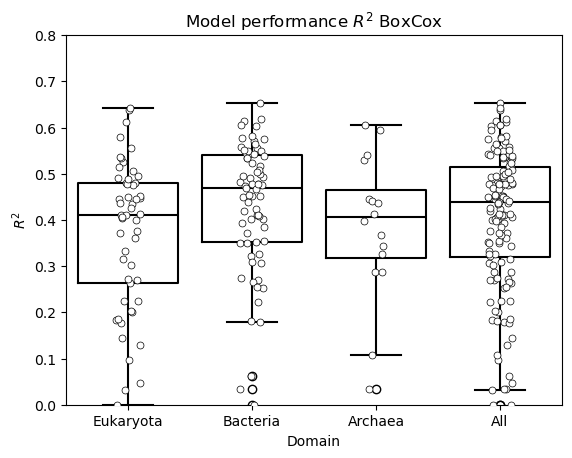

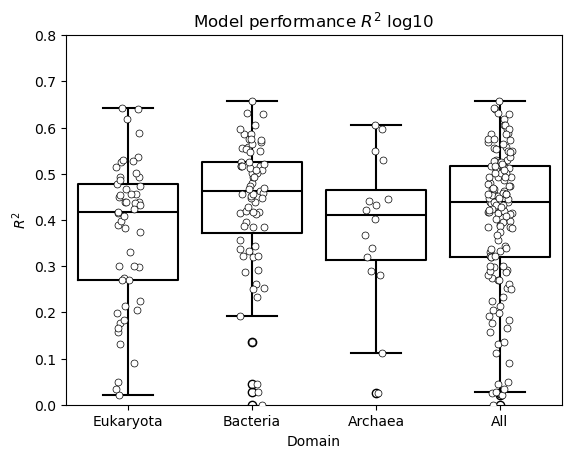

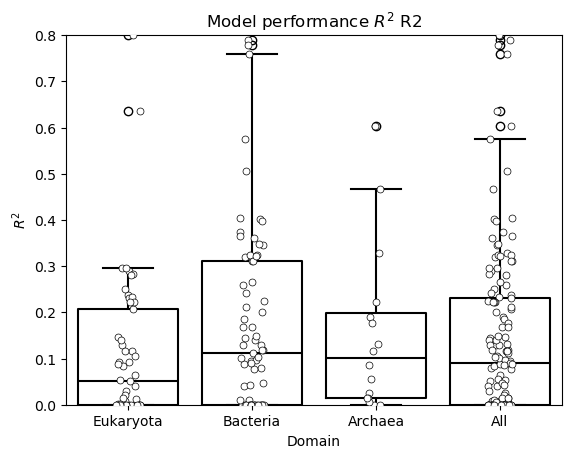

In [29]:
for transformation in ["R2_BoxCox", "R2_log10", "R2"]:
    f, ax = plt.subplots(1)
    sns.boxplot(data=df.loc[df["Type"]=="Median"], x="Domain", y=transformation, ax = ax, fill=False, color="k")#, palette={"Median":"white", "Experiment":"C2"})
    sns.stripplot(data=df.loc[df["Type"]=="Median"], x="Domain", y=transformation, ax = ax,facecolor="white", edgecolor="k", linewidth=0.5)
    ax.set_title(fr"Model performance $R^2$ {transformation.split('_')[-1]}")
    ax.set_ylim([0,0.8])
    ax.set_ylabel(r"$R^2$")
    plt.savefig(f"../../result/2024-0829/ModelPerformance_{transformation}_domains_of_life.pdf")

In [75]:
def labelmaker2000(x):
    if x == "ho2018":
        return "S. cerevisiae (ho2018)"
    try:
        return ". ".join([ rec.strip('[')[0] if idx==0 else rec for idx, rec in enumerate(ncbi.get_taxid_translator([x])[int(x)].split()[:2])]) + f" ({x})"
    except:
        return x

df=df.assign(Name=df["Tax_id"].map(labelmaker2000))



In [409]:
df.iloc[df.loc[df["Tax_id"]=="ho2018"]["R2_BoxCox"].idxmax()]

Tax_id                         ho2018
Domain                      Eukaryota
Type                           Median
R2                           0.476984
R2_log10                     0.602464
R2_BoxCox                    0.601566
RMSE                     10354.417271
RMSE_log10                   0.335106
RMSE_BoxCox                  0.748052
Name           S. cerevisiae (ho2018)
Name: 67, dtype: object

In [407]:
df.iloc[df.loc[df["Type"]=="Median"]["R2_BoxCox"].idxmax()]

Tax_id                     284590
Domain                  Eukaryota
Type                       Median
R2                      -2.306168
R2_log10                  0.64013
R2_BoxCox                0.637899
RMSE                  1764.359892
RMSE_log10               0.374354
RMSE_BoxCox              0.561946
Name           K. lactis (284590)
Name: 76, dtype: object

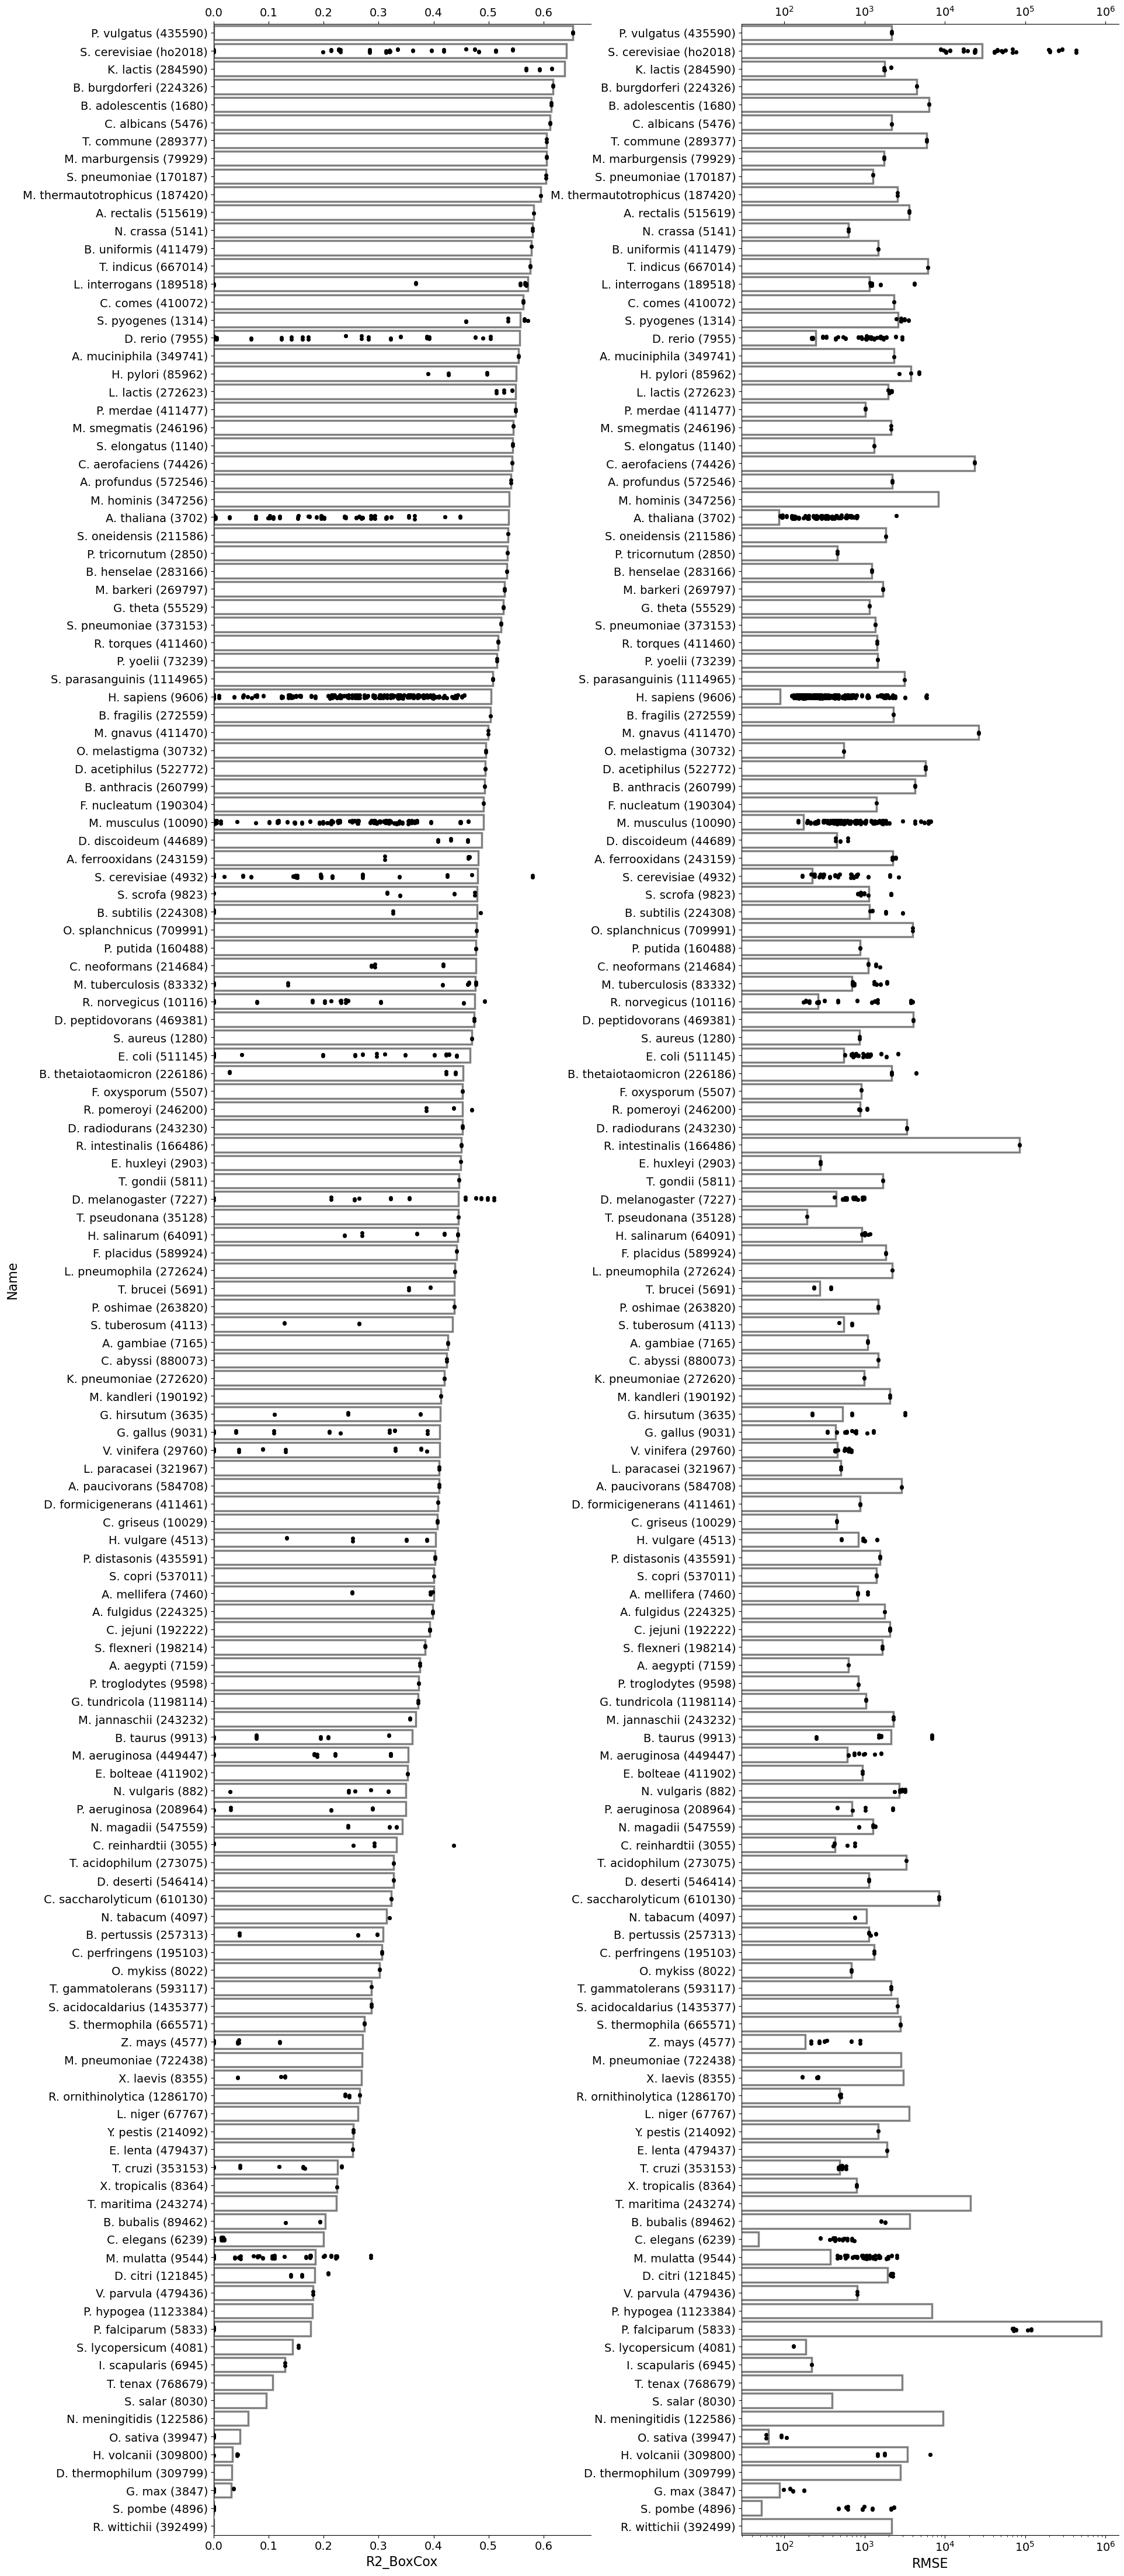

In [386]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
f, axs = plt.subplots(1,2, figsize=[20, 50])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.96      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
axs[0].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
axs[1].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)


#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
axs[0].spines['right'].set_color('white')
axs[1].spines['right'].set_color('white')
#ax.spines['left'].set_color('white')

order = df.loc[df["Type"]=="Median"].sort_values(by="R2_BoxCox", ascending=False)["Name"].unique()
df_tmp_median = df.loc[df["Type"]=="Median"]
df_tmp_median = df_tmp_median.assign(R2_BoxCox=df_tmp_median["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.barplot(data=df_tmp_median,x="R2_BoxCox", y="Name", ax=axs[0], order=order, linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )

df_tmp_experiment = df.loc[df["Type"]=="Experiment"]
df_tmp_experiment =df_tmp_experiment.assign(R2_BoxCox=df_tmp_experiment["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.stripplot(data=df_tmp_experiment,x="R2_BoxCox", y="Name", ax=axs[0], order=order, color="k")


sns.barplot(data=df.loc[df["Type"]=="Median"],x="RMSE", y="Name", ax=axs[1], order=order , linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )
sns.stripplot(data=df.loc[df["Type"]=="Experiment"],x="RMSE", y="Name", ax=axs[1], order=order, color="k")

#axs[0].set_xlim([0,1])
axs[1].set_xscale("log")
axs[1].set_ylabel("")
#f.suptitle("Model performance on median abundance values from 139 organisms and Ho2018")
plt.savefig("../../result/2024-0829/Model_performance_Median_and_experiment.pdf",bbox_inches="tight")
plt.show()


In [52]:
index_tax_id_with_five_experiments

Index(['10090', '10116', '1314', '189518', '29760', '353153', '3702', '449447',
       '4577', '4896', '4932', '511145', '5833', '6239', '64091', '7227',
       '7955', '83332', '882', '9031', '9544', '9606', '9823', '9913',
       'ho2018'],
      dtype='object', name='Tax_id')

In [51]:
index_tax_id_with_five_experiments = df_tmp.groupby("Tax_id").count().loc[df_tmp.groupby("Tax_id").count()["Domain"] > 5 ].index

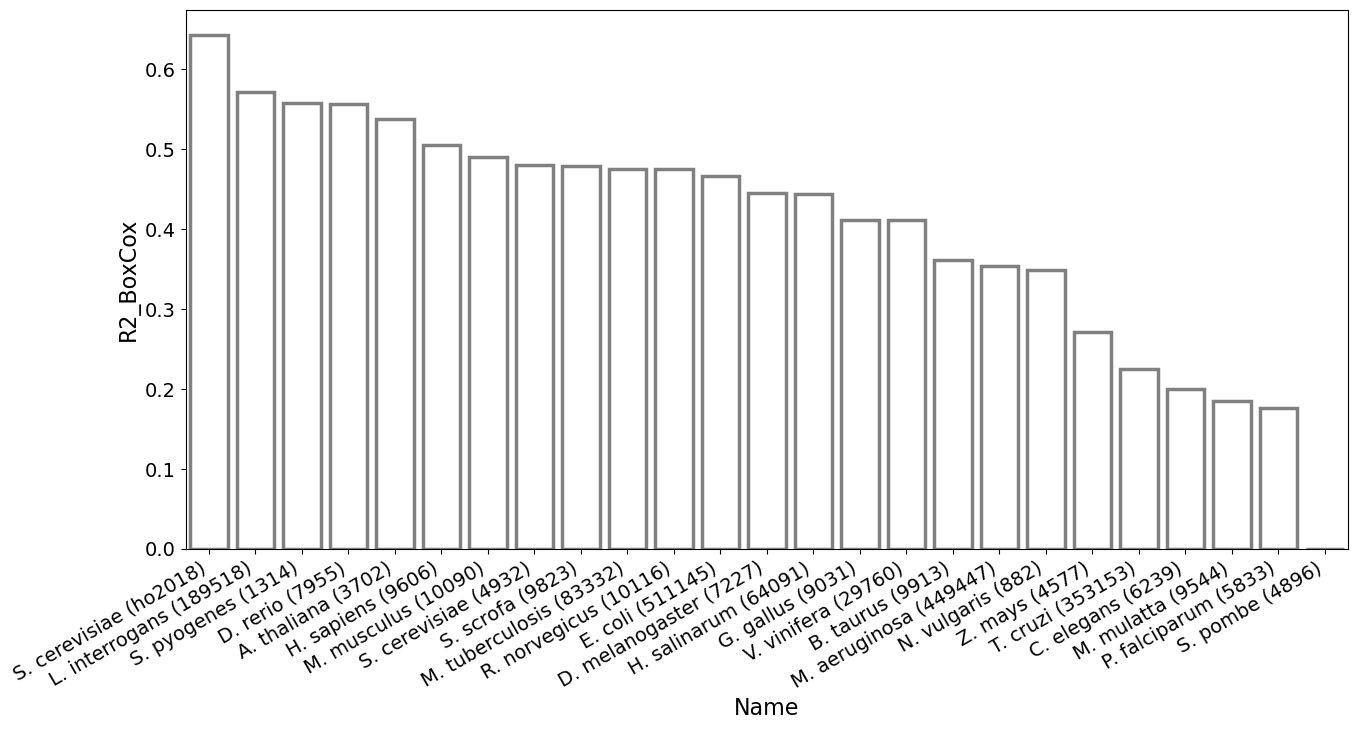

In [61]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
f, axs = plt.subplots(1, figsize=[15, 7])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.96      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

#f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
#axs.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)



#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
#axs.spines['right'].set_color('white')

#ax.spines['left'].set_color('white')
df_tmp = df.loc[df["Tax_id"].isin(index_tax_id_with_five_experiments)]
order = df_tmp.loc[df_tmp["Type"]=="Median"].sort_values(by="R2_BoxCox", ascending=False)["Name"].unique()
df_tmp_median = df_tmp.loc[df_tmp["Type"]=="Median"]
df_tmp_median = df_tmp_median.assign(R2_BoxCox=df_tmp_median["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.barplot(data=df_tmp_median,y="R2_BoxCox", x="Name", ax=axs, order=order, linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )

plt.xticks(rotation=30, horizontalalignment="right")




#f.suptitle("Model performance on median abundance values from 139 organisms and Ho2018")
plt.savefig("../../result/2024-0829/Model_performance_Median_atLeast_5experiments.pdf",bbox_inches="tight")
plt.show()

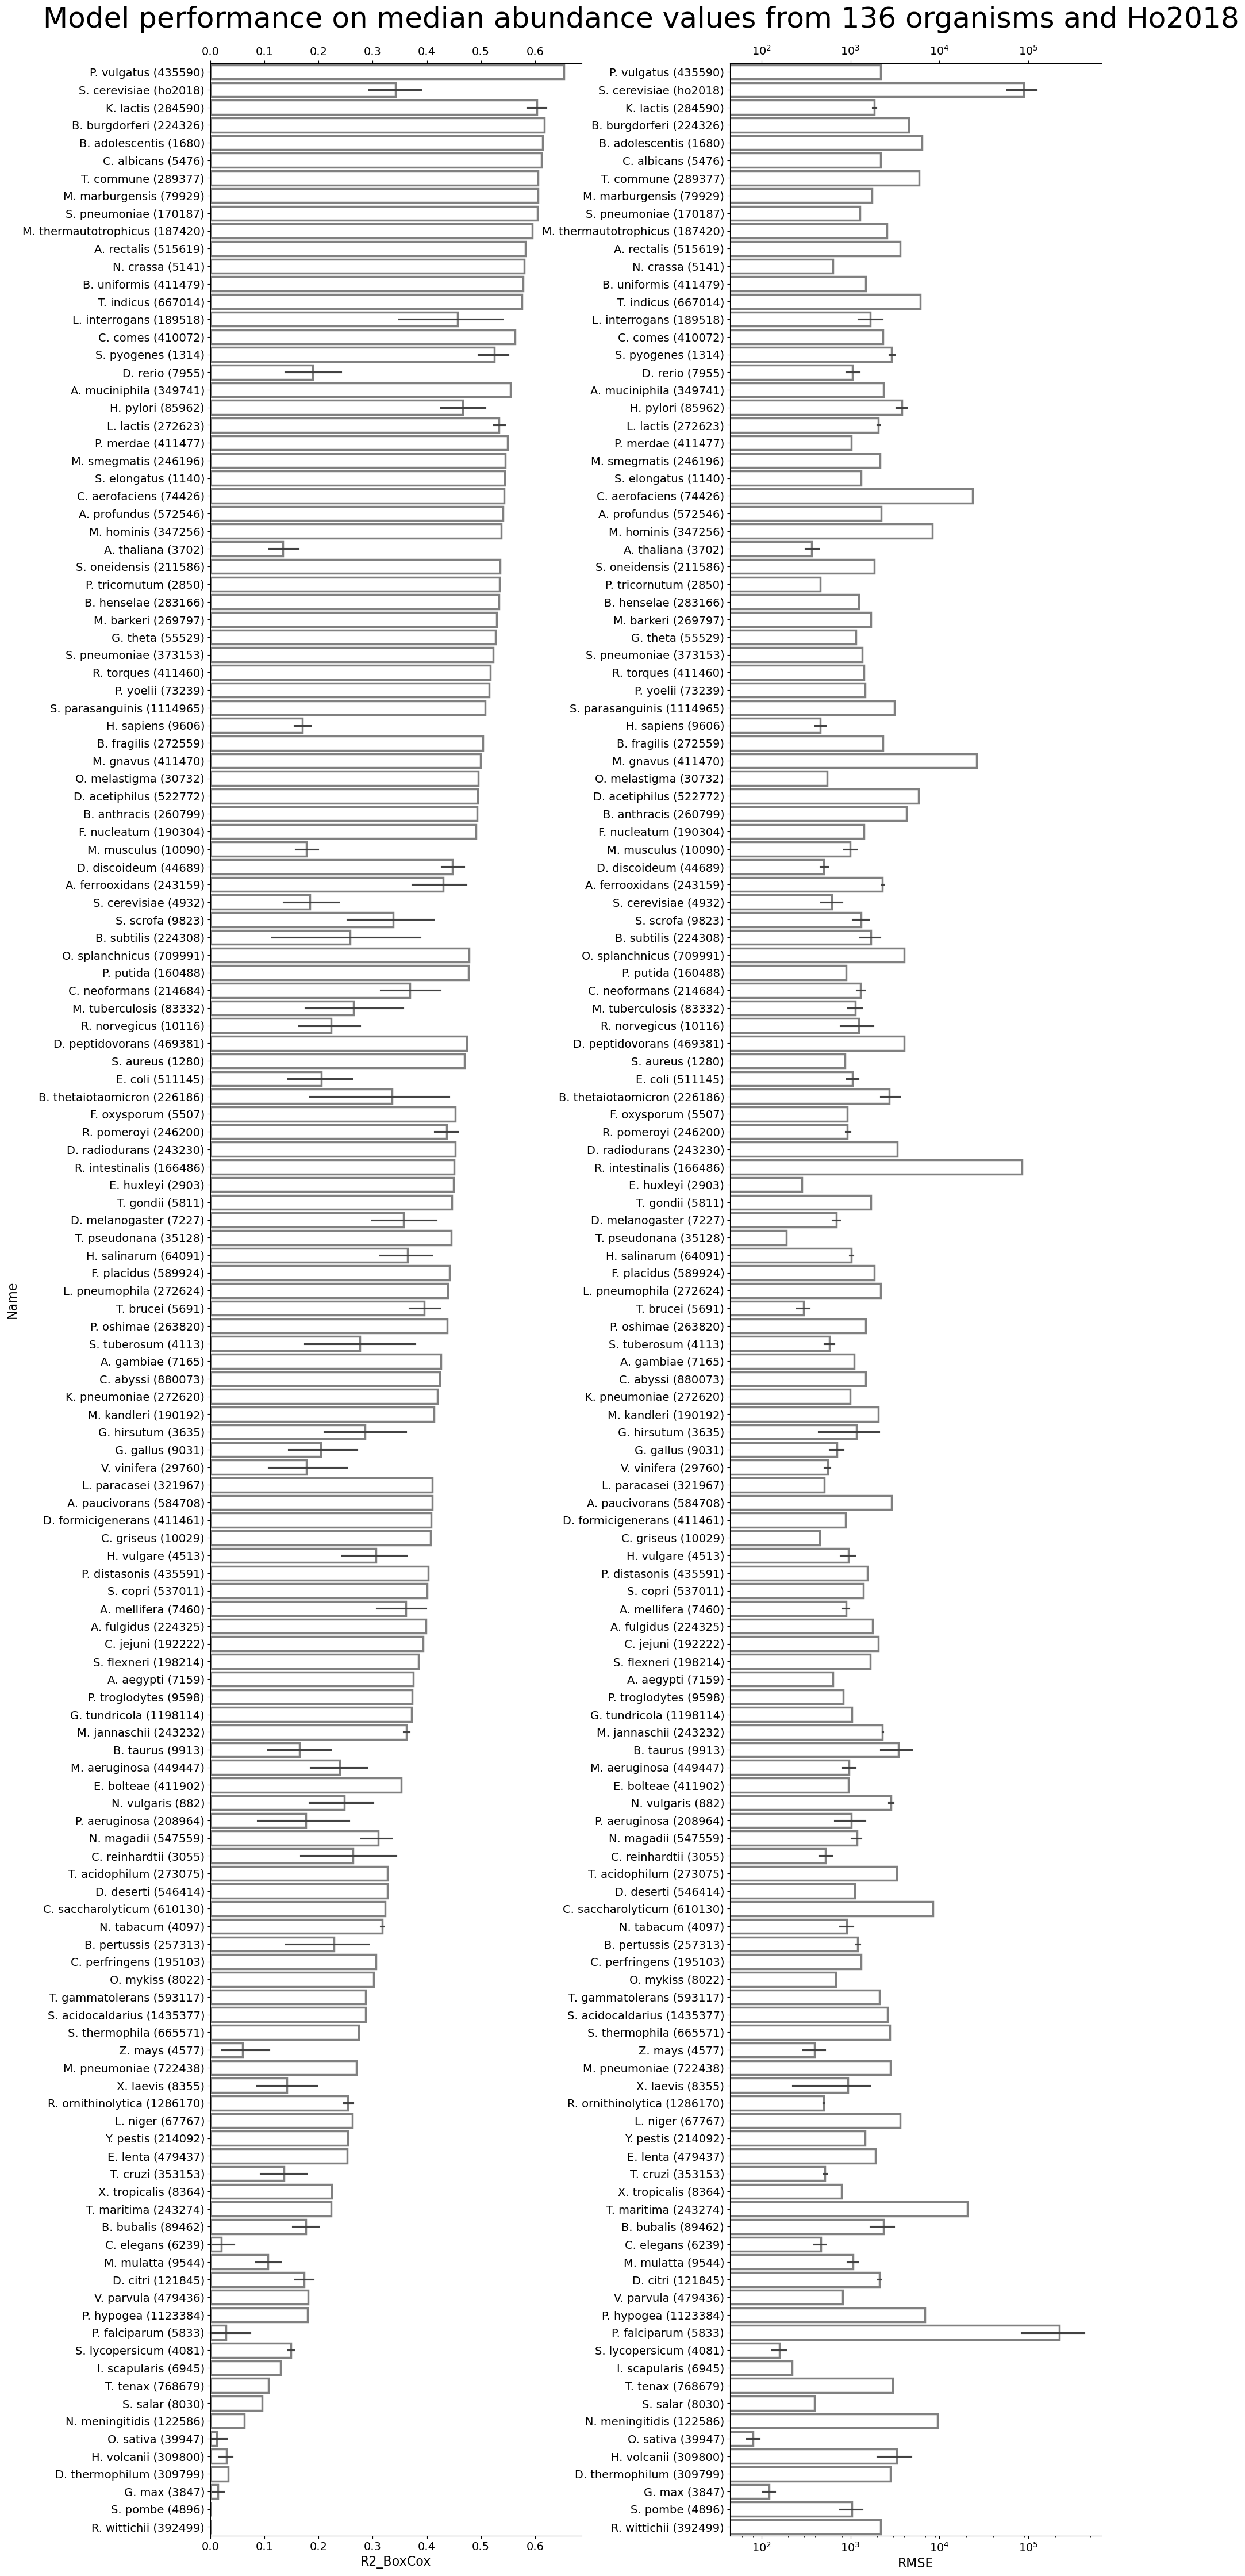

In [387]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
f, axs = plt.subplots(1,2, figsize=[20, 50])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.96      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
axs[0].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
axs[1].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)


#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
axs[0].spines['right'].set_color('white')
axs[1].spines['right'].set_color('white')
#ax.spines['left'].set_color('white')

order = df.loc[df["Type"]=="Median"].sort_values(by="R2_BoxCox", ascending=False)["Name"].unique()
df_tmp_median = df
df_tmp_median = df_tmp_median.assign(R2_BoxCox=df_tmp_median["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.barplot(data=df_tmp_median,x="R2_BoxCox", y="Name", ax=axs[0], order=order, linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )


sns.barplot(data=df_tmp_median,x="RMSE", y="Name", ax=axs[1], order=order , linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )


#axs[0].set_xlim([0,1])
axs[1].set_xscale("log")
axs[1].set_ylabel("")
f.suptitle("Model performance on median abundance values from 136 organisms and Ho2018")
plt.savefig("../../result/2024-0829/Model_performance_Median_and_experiment_errorbar.pdf",bbox_inches="tight")
plt.show()

In [404]:
files = glob.glob("../../data/PaxDb/Paxdb-sequences_processed_subset/*/training_df_0.pkl")



df = {"Tax_id": [], "Domain":[], "Type":[], "R2":[], "R2_log10":[], "R2_BoxCox":[], "RMSE":[], "RMSE_log10":[],"RMSE_BoxCox":[]}

for file in tqdm(files):
    taxon_id = file.split("/")[-2]
    with open(file, "br") as f:
        df_tmp = pkl.load(f)
    domain = get_domain(taxon_id)
    # Add median valuse
    df["Tax_id"].append(taxon_id)
    df["Domain"].append(get_domain(taxon_id))
    df["Type"].append("Median")
    true = df_tmp['train_stat']['Test_True']
    pred = df_tmp['train_stat']['Test_Eval']
    df["R2"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=False))
    df["R2_BoxCox"].append(calc_R2(true, pred, lam = None, log=False))
    df["R2_log10"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=True))
    df["RMSE"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=False))
    df["RMSE_BoxCox"].append(calc_RMSE(true, pred, lam = None, log=False))
    df["RMSE_log10"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=True))

    # Add experiment values

    for true, pred in zip(df_tmp['train_stat']['Test_experiment_True'], df_tmp['train_stat']['Test_experiment_Eval']):
        df["Tax_id"].append(taxon_id)
        df["Domain"].append(get_domain(taxon_id))
        df["Type"].append("Experiment")
        df["R2"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=False))
        df["R2_BoxCox"].append(calc_R2(true, pred, lam = None, log=False))
        df["R2_log10"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=True))
        df["RMSE"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=False))
        df["RMSE_BoxCox"].append(calc_RMSE(true, pred, lam = None, log=False))
        df["RMSE_log10"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=True))
df = pd.DataFrame(df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:11<00:00,  2.29it/s]


In [405]:
def labelmaker2000(x):
    if x == "ho2018":
        return "S. cerevisiae (ho2018)"
    try:
        return ". ".join([ rec.strip('[')[0] if idx==0 else rec for idx, rec in enumerate(ncbi.get_taxid_translator([x])[int(x)].split()[:2])]) + f" ({x})"
    except:
        return x

df=df.assign(Name=df["Tax_id"].map(labelmaker2000))

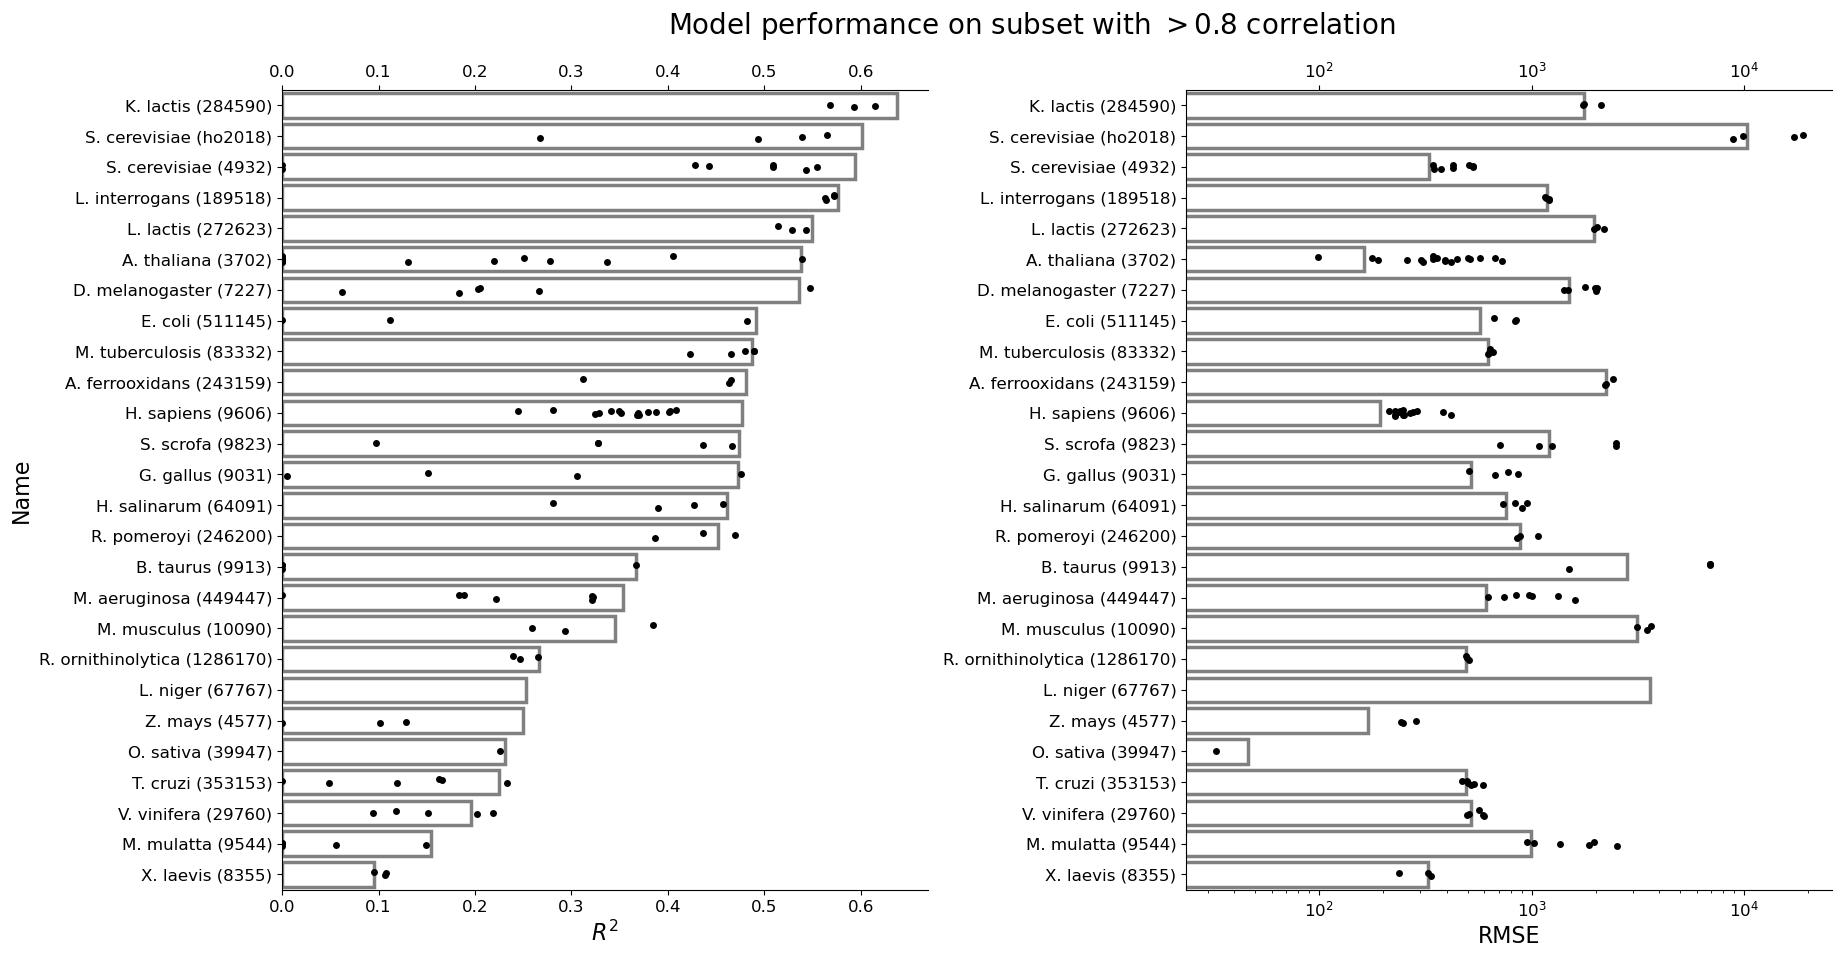

In [380]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
f, axs = plt.subplots(1,2, figsize=[20, 10])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
axs[0].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
axs[1].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)


#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
axs[0].spines['right'].set_color('white')
axs[1].spines['right'].set_color('white')
#ax.spines['left'].set_color('white')

order = df.loc[df["Type"]=="Median"].sort_values(by="R2_BoxCox", ascending=False)["Name"].unique()
df_tmp_median = df.loc[df["Type"]=="Median"]
df_tmp_median = df_tmp_median.assign(R2_BoxCox=df_tmp_median["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.barplot(data=df_tmp_median,x="R2_BoxCox", y="Name", ax=axs[0], order=order, linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )

df_tmp_experiment = df.loc[df["Type"]=="Experiment"]
df_tmp_experiment =df_tmp_experiment.assign(R2_BoxCox=df_tmp_experiment["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.stripplot(data=df_tmp_experiment,x="R2_BoxCox", y="Name", ax=axs[0], order=order, color="k")


sns.barplot(data=df.loc[df["Type"]=="Median"],x="RMSE", y="Name", ax=axs[1], order=order , linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )
sns.stripplot(data=df.loc[df["Type"]=="Experiment"],x="RMSE", y="Name", ax=axs[1], order=order, color="k")

#axs[0].set_xlim([0,1])
axs[1].set_xscale("log")
axs[1].set_ylabel("")
axs[0].set_xlabel(r"$R^2$")
f.suptitle(r"Model performance on subset with $>0.8$ correlation")
plt.savefig("../../result/2024-0829/Model_performance_Median_and_experiment_subset.pdf", dpi=400)
plt.show()

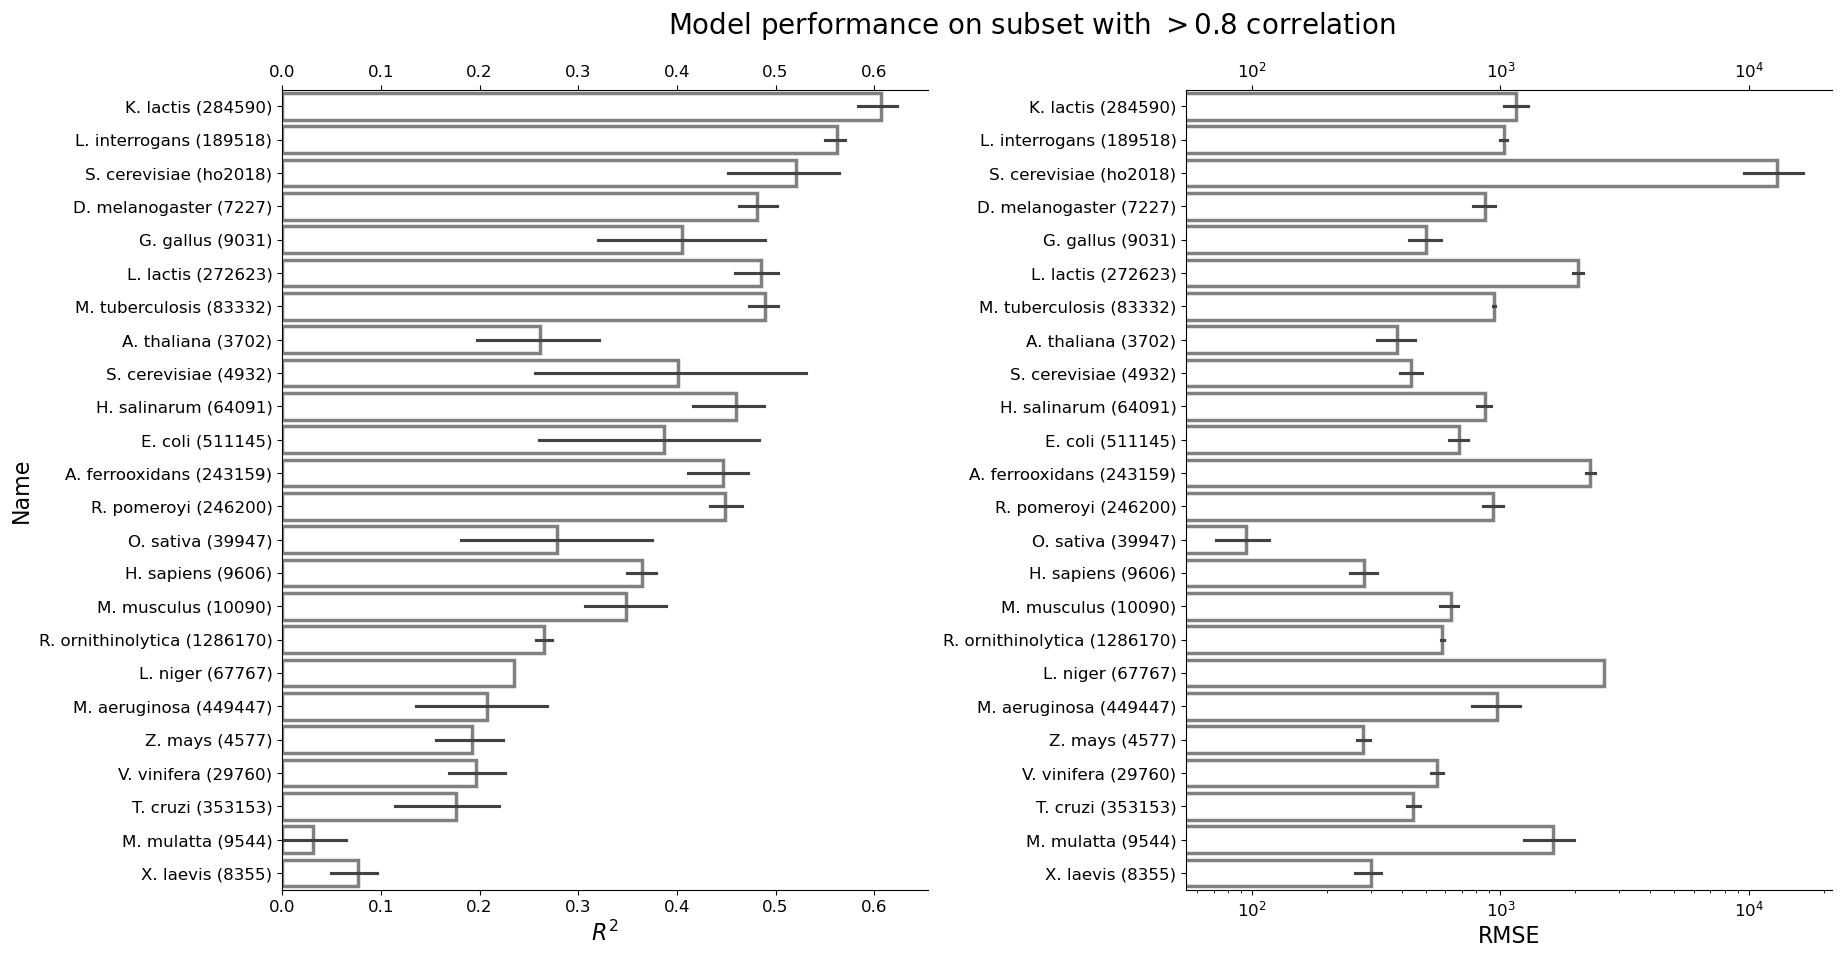

In [260]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
f, axs = plt.subplots(1,2, figsize=[20, 10])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
axs[0].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
axs[1].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)


#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
axs[0].spines['right'].set_color('white')
axs[1].spines['right'].set_color('white')
#ax.spines['left'].set_color('white')

order = df.loc[df["Type"]=="Median"].sort_values(by="R2_BoxCox", ascending=False)["Name"].unique()
df_tmp_median = df
df_tmp_median = df_tmp_median.assign(R2_BoxCox=df_tmp_median["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.barplot(data=df_tmp_median,x="R2_BoxCox", y="Name", ax=axs[0], order=order, linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )


sns.barplot(data=df_tmp_median,x="RMSE", y="Name", ax=axs[1], order=order , linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )


#axs[0].set_xlim([0,1])
axs[1].set_xscale("log")
axs[1].set_ylabel("")
axs[0].set_xlabel(r"$R^2$")
f.suptitle(r"Model performance on subset with $>0.8$ correlation")
plt.savefig("../../result/2024-0829/Model_performance_Median_and_experiment_subset_errorbar", dpi=400)
plt.show()

# Human tissue

In [388]:
files = glob.glob("../../data/PaxDb/Paxdb-sequences_processed_Human_tissue/*/training_df_0.pkl")



df = {"Tax_id": [], "Domain":[], "Type":[], "R2":[], "R2_log10":[], "R2_BoxCox":[], "RMSE":[], "RMSE_log10":[],"RMSE_BoxCox":[]}

for file in tqdm(files):
    taxon_id = file.split("/")[-2]
    with open(file, "br") as f:
        df_tmp = pkl.load(f)
    domain = taxon_id
    try:
        # Add median valuse

        true = df_tmp['train_stat']['Test_True']
        pred = df_tmp['train_stat']['Test_Eval']
        df["R2"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=False))
        df["R2_BoxCox"].append(calc_R2(true, pred, lam = None, log=False))
        df["R2_log10"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=True))
        df["RMSE"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=False))
        df["RMSE_BoxCox"].append(calc_RMSE(true, pred, lam = None, log=False))
        df["RMSE_log10"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=True))
        df["Tax_id"].append(taxon_id)
        df["Domain"].append(taxon_id)
        df["Type"].append("Median")
    
        # Add experiment values
    
        for true, pred in zip(df_tmp['train_stat']['Test_experiment_True'], df_tmp['train_stat']['Test_experiment_Eval']):
            df["Tax_id"].append(taxon_id)
            df["Domain"].append(taxon_id)
            df["Type"].append("Experiment")
            df["R2"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=False))
            df["R2_BoxCox"].append(calc_R2(true, pred, lam = None, log=False))
            df["R2_log10"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=True))
            df["RMSE"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=False))
            df["RMSE_BoxCox"].append(calc_RMSE(true, pred, lam = None, log=False))
            df["RMSE_log10"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=True))
    except:
        print(f"skipping: {file}")
df = pd.DataFrame(df)

def labelmaker2000(x):
    if x == "ho2018":
        return "S. cerevisiae (ho2018)"
    try:
        return ". ".join([ rec.strip('[')[0] if idx==0 else rec for idx, rec in enumerate(ncbi.get_taxid_translator([x])[int(x)].split()[:2])]) + f" ({x})"
    except:
        return x

df=df.assign(Name=df["Tax_id"])

 18%|████████████████████▍                                                                                              | 11/62 [00:04<00:11,  4.28it/s]

skipping: ../../data/PaxDb/Paxdb-sequences_processed_Human_tissue/ARTERIAL_BLOOD_VESSEL/training_df_0.pkl


 27%|███████████████████████████████▌                                                                                   | 17/62 [00:07<00:19,  2.27it/s]

skipping: ../../data/PaxDb/Paxdb-sequences_processed_Human_tissue/CARDIAC_ATRIUM/training_df_0.pkl


 31%|███████████████████████████████████▏                                                                               | 19/62 [00:07<00:17,  2.52it/s]

skipping: ../../data/PaxDb/Paxdb-sequences_processed_Human_tissue/ATRIOVENTRICULAR_VALVE/training_df_0.pkl


 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 47/62 [00:22<00:11,  1.29it/s]

skipping: ../../data/PaxDb/Paxdb-sequences_processed_Human_tissue/CORONARY_VESSEL/training_df_0.pkl


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 59/62 [00:26<00:01,  2.53it/s]

skipping: ../../data/PaxDb/Paxdb-sequences_processed_Human_tissue/CARDIAC_VENTRICLE/training_df_0.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:27<00:00,  2.24it/s]


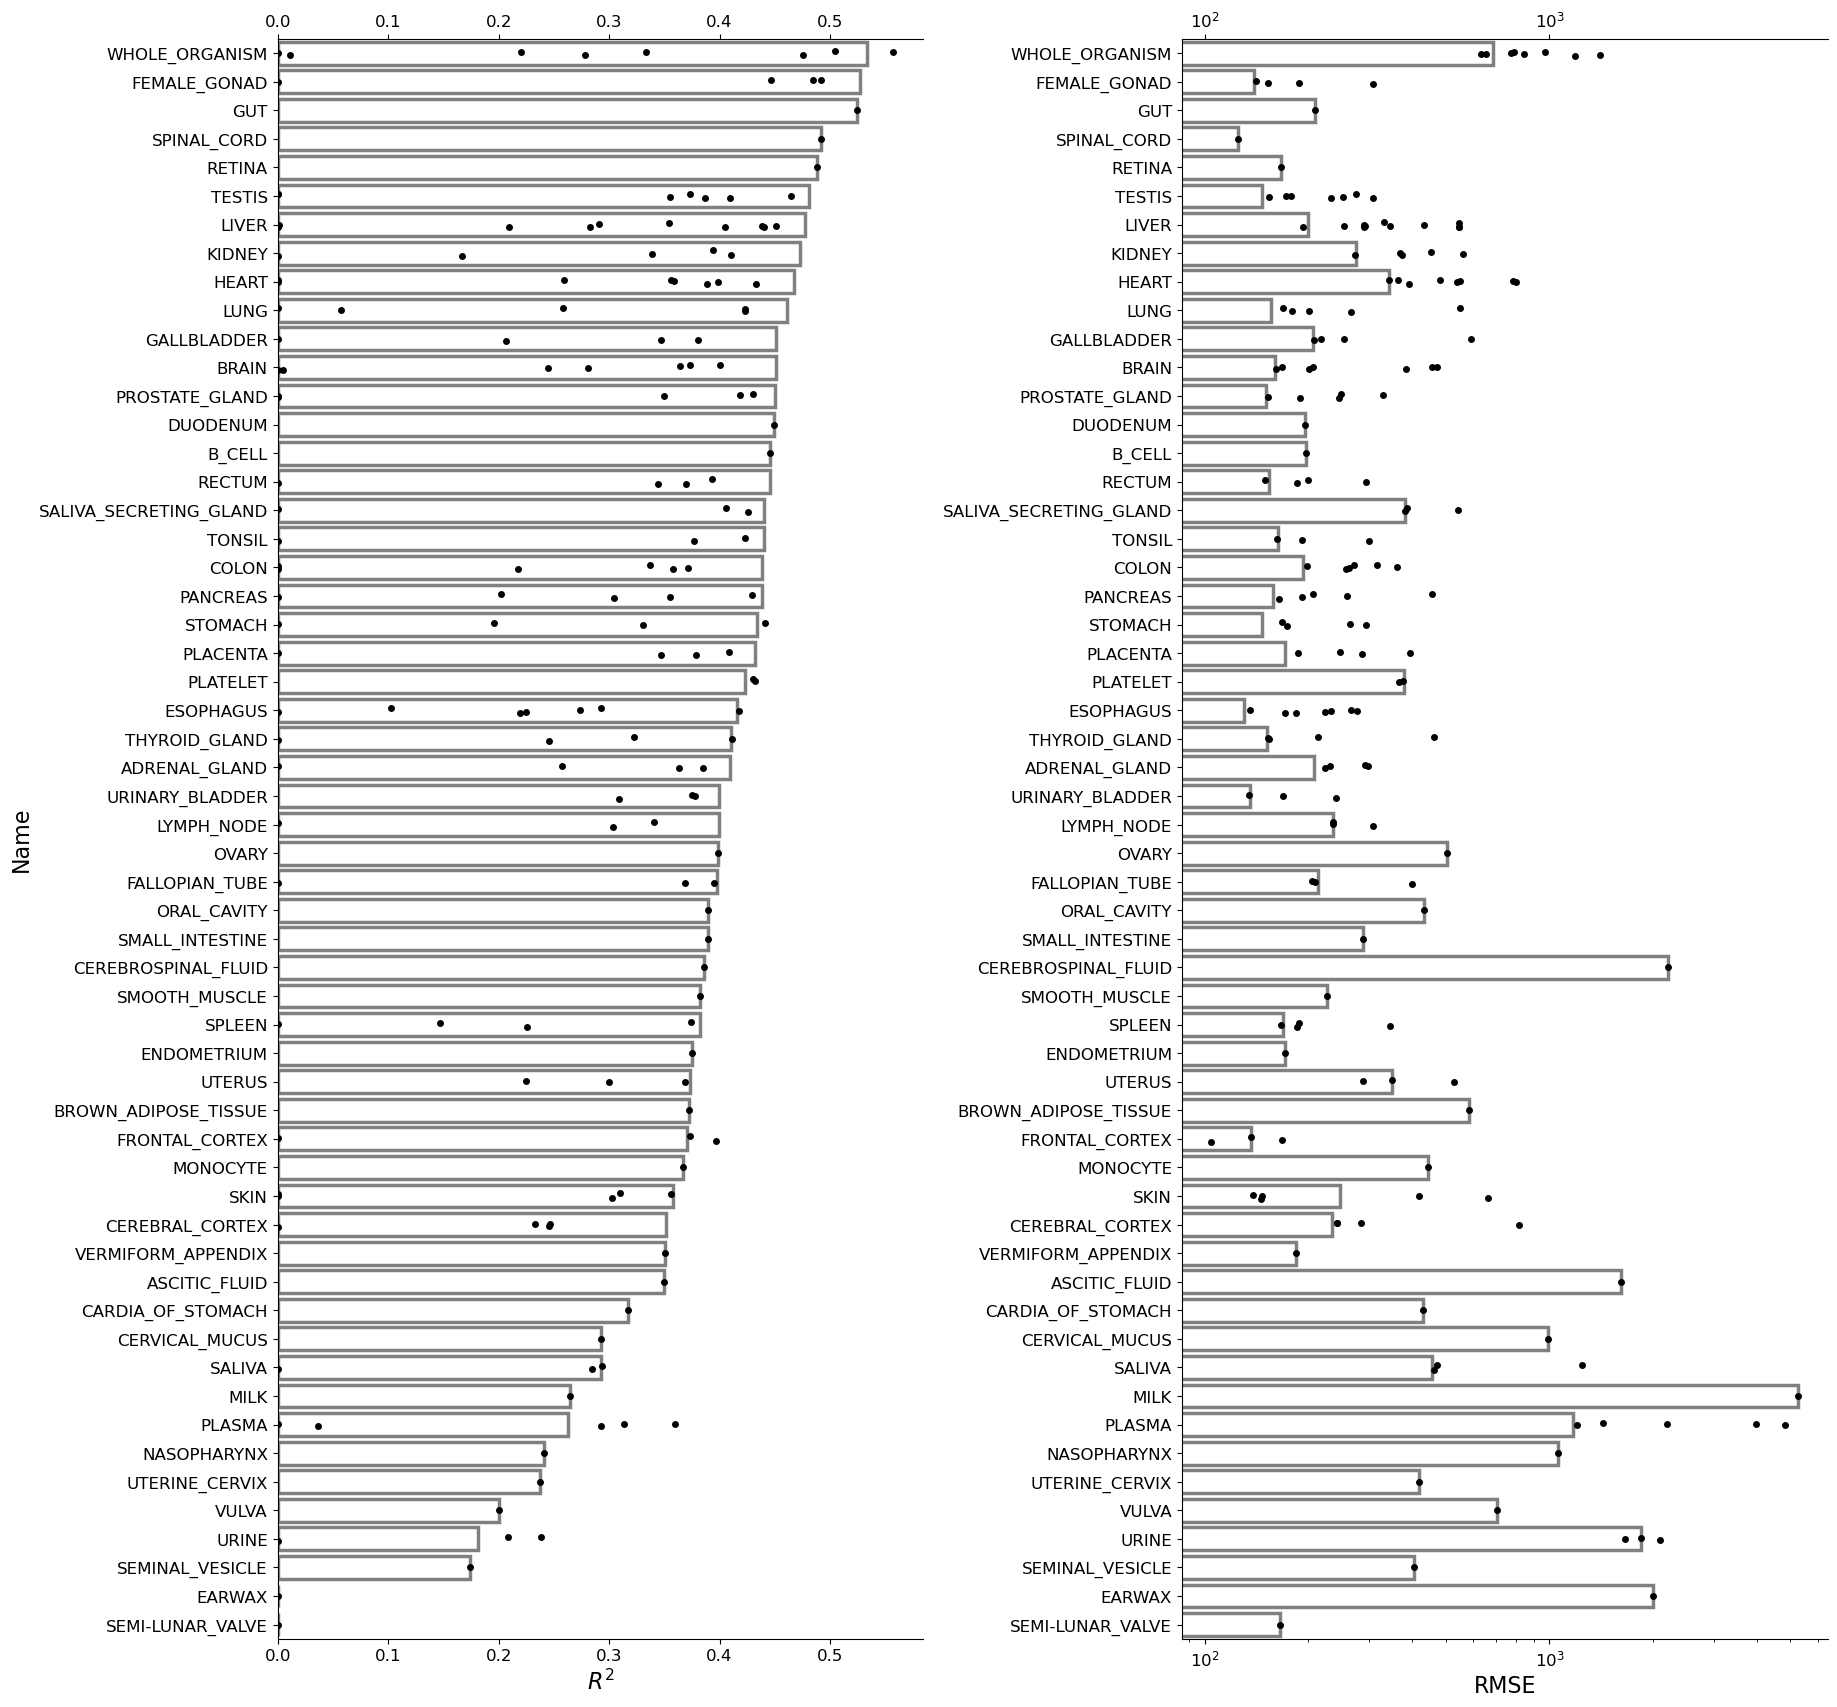

In [389]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
f, axs = plt.subplots(1,2, figsize=[20, 20])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
axs[0].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
axs[1].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)


#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
axs[0].spines['right'].set_color('white')
axs[1].spines['right'].set_color('white')
#ax.spines['left'].set_color('white')

df = df.loc[df["Tax_id"]!="CELL_LINE"]

order = df.loc[df["Type"]=="Median"].sort_values(by="R2_BoxCox", ascending=False)["Name"].unique()
df_tmp_median = df.loc[df["Type"]=="Median"]
df_tmp_median = df_tmp_median.assign(R2_BoxCox=df_tmp_median["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.barplot(data=df_tmp_median,x="R2_BoxCox", y="Name", ax=axs[0], order=order, linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )

df_tmp_experiment = df.loc[df["Type"]=="Experiment"]
df_tmp_experiment =df_tmp_experiment.assign(R2_BoxCox=df_tmp_experiment["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.stripplot(data=df_tmp_experiment,x="R2_BoxCox", y="Name", ax=axs[0], order=order, color="k")


sns.barplot(data=df.loc[df["Type"]=="Median"],x="RMSE", y="Name", ax=axs[1], order=order , linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )
sns.stripplot(data=df.loc[df["Type"]=="Experiment"],x="RMSE", y="Name", ax=axs[1], order=order, color="k")

#axs[0].set_xlim([0,1])
axs[1].set_xscale("log")
axs[1].set_ylabel("")
axs[0].set_xlabel(r"$R^2$")
#f.suptitle(r"Model performance on Human tissue")
plt.savefig("../../result/2024-0829/Model_performance_Median_and_experiment_Human_tissue.pdf")
plt.show()

In [319]:
df_tmp_median["Tax_id"].unique().shape

(57,)

In [338]:
def read_paxdb_dataset(path) -> pd.DataFrame:
    organism = inp.split("/")[-1]
    dset = pd.read_csv(path, sep = '\t', header=11)
    dset = dset.rename(columns = {'#string_external_id': 'id'})
    dset['id'] = dset['id'].map(str)
    if organism != "ho2018":
        dset['id'] = dset['id'].map(lambda s: s.split('.')[1])
    return dset

def load_train_test_split(inp):
    organism = inp.split("/")[-1]
    training_partition_file = f"{inp}/train.fa"
    train_ids = pd.read_csv(training_partition_file, sep=" ", names=["id", "count"])
    if organism != "ho2018":
        train_ids["id"] = train_ids.apply(lambda x: x["id"].split(".")[1], axis = 1)
    train_ids = train_ids["id"].to_list()
    
    test_partition_file = f"{inp}/test.fa"
    test_ids = pd.read_csv(test_partition_file, sep=" ", names=["id", "count"])
    if organism != "ho2018":
        test_ids["id"] = test_ids.apply(lambda x: x["id"].split(".")[1], axis = 1)
    test_ids = test_ids["id"].to_list()

    return train_ids, test_ids

def load_abundance(inp):
    experiment_files = glob.glob(f"{inp}/experiments/*.txt")
    experiment_DataFrame_list = list(map(read_paxdb_dataset, experiment_files))
    print(f"Loaded: {len(experiment_DataFrame_list)} experiments")
    return experiment_DataFrame_list
    
def calc_median_abundance(experiment_DataFrame_list):
    df_tmp = pd.concat(experiment_DataFrame_list)
    df_tmp = df_tmp.groupby(by="id").median().reset_index()
    print(f"Median data frame contains {df_tmp.shape[0]} proteins")
    return df_tmp

def extract_experiment_test_abundance(embedding_df, experiment_DataFrame_list, test_ids, lam):
    experiment_test, experiment_test_id = [], []
    
    for experiment in experiment_DataFrame_list:
        
        experiment_tmp = experiment.loc[experiment["id"].isin(test_ids)]
        experiment_tmp = embedding_df.merge(experiment_tmp, on = "id", how="inner")
        if experiment_tmp.shape[0] < 100:
            print(f"Skipping experiment with {experiment_tmp.shape[0]} overlapping sequences")
            continue
        X_test = experiment_tmp["Embedding"].to_list()
        y_test = experiment_tmp["abundance"].to_list()
        y_ids  = experiment_tmp["id"].to_list()
        y_test_transform = boxcox(y_test, lam)
        experiment_test.append(list(zip(X_test,y_test_transform.astype(np.float32))))
        experiment_test_id.append(y_ids)

    print(f"Prepared: {len(experiment_test)} Experiment test sets")
    return experiment_test, experiment_test_id

#def check_no_dot_id(df):
#    ids = df["id"].to_list()
#    ids_new = []
#    for id_ in ids:
#        if "." in id_:
            

def make_df(inp = "../../data/PaxDb/Paxdb-sequences_processed/10090/"):
    data_df = {}
    
    embedding_file = f"{inp}/embedding.pkl"
    organism = inp.split("/")[-1]
    assert embedding_file[-3:] == "pkl", "Embedding is Not pickle file"
            
    with open(embedding_file, "br") as f:
        embedding_df = pkl.load(f)
        embedding_df["Embedding"] = embedding_df["Embedding"][:len(embedding_df["id"])] # Make sure to remove last two copys of embeddings  ( bug from embedings calc script)

    embedding_df = pd.DataFrame(embedding_df)
    if organism != "ho2018":
        try:
            embedding_df["id"] = embedding_df.apply(lambda x: x["id"].split(".")[1], axis = 1)
        except:

            print("Not using species in id")
    #print("Embedding df")
    #print(embedding_df)
    
    abundance_df_list = load_abundance(inp)
    abundance_median_df = calc_median_abundance(abundance_df_list)

    #print("Abundance df")
    #print(abundance_median_df)
    tmp_df = embedding_df.merge(abundance_median_df, on = "id", how="inner")

    #print("Merge df")
    #print(tmp_df)
    
    train_ids, test_ids = load_train_test_split(inp)

    #print(f"train ids: {train_ids}")

    train_df = tmp_df.loc[tmp_df["id"].isin(train_ids)]

    print("Train df")
    print(train_df)

    X_train = train_df["Embedding"].to_list()
    y_train = train_df["abundance"].to_list()

    test_df = tmp_df.loc[tmp_df["id"].isin(test_ids)]
inp = "../../data/PaxDb/Paxdb-sequences_processed/10090/"
df = make_df(inp)

Loaded: 106 experiments
Median data frame contains 20846 proteins
Train df
                       id                                                seq  \
1      ENSMUSP00000000003  MMRVIILLLTLHVLGVSSVMSLKKKIDGPWQTIYLAASTMEKINEG...   
6      ENSMUSP00000000080  MKLSPALPGTVSARTPDRSPPCFPDSEDCLFQPDMDVLPMCSIFQE...   
13     ENSMUSP00000000129  MGFGSDLKNSQEAVLKLQDWELRLLETVKKFMALRIKSDKEYAYTL...   
20     ENSMUSP00000000187  MALGQRLFITMSRGAGRVQGTLQALVFLGVLVGMVVPSPAGARANG...   
22     ENSMUSP00000000193  MQVPVMLLGLLFTVAGWSIHVLAQPDAVNAPLTCCYSFTSKMIPMS...   
...                   ...                                                ...   
19802  ENSMUSP00000141054  MTTAILERLSTLSMSGQQLRRLPKILEEGLPKMPCTVPETDVPQLF...   
19804  ENSMUSP00000141087  MNVGVAHSEVNPNTRVMNSRGMWLTYALGVGLLHIVLLSIPFCSVP...   
19808  ENSMUSP00000141107  MADVSERTLQVSVLVAFASGVVLGWQANRLRRRYLDWRKRRLQDKL...   
19814  ENSMUSP00000141121  MGSGSSRSGRIPRRRRSPDRRQTGPGETASEGGTADQARTAAGQEE...   
19818  ENSMUSP00000141169  MEQRHSLAGNCDDGEKSE

In [374]:
list_training_length = []
list_testing_length  = []
paths = glob.glob("../../data/PaxDb/Paxdb-sequences_processed/*/training_df_0.pkl")
for path in paths:
    with open(path, "br") as f:
        df_tmp = pkl.load(f)
        list_training_length.append(len(df_tmp["train"]))
        list_testing_length.append(len(df_tmp["test"]))
        #print(f"ID: {path.split('/')[-2]}, Training length: {len(df_tmp['train']):4d} Testing length: {len(df_tmp['test']):4d} ")
print(f"Minimum size of training set {min(list_training_length)}")
print(f"Minimum size of test set {min(list_testing_length)}")

Minimum size of training set 231
Minimum size of test set 66


# Cell lines

In [368]:
files = glob.glob("../../data/PaxDb/Paxdb-sequences_processed_Human_cell_line/*/training_df_0.pkl")



df = {"Tax_id": [], "Domain":[], "Type":[], "R2":[], "R2_log10":[], "R2_BoxCox":[], "RMSE":[], "RMSE_log10":[],"RMSE_BoxCox":[]}

for file in tqdm(files):
    taxon_id = file.split("/")[-2]
    with open(file, "br") as f:
        df_tmp = pkl.load(f)
    domain = taxon_id
    try:
        # Add median valuse

        true = df_tmp['train_stat']['Test_True']
        pred = df_tmp['train_stat']['Test_Eval']
        df["R2"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=False))
        df["R2_BoxCox"].append(calc_R2(true, pred, lam = None, log=False))
        df["R2_log10"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=True))
        df["RMSE"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=False))
        df["RMSE_BoxCox"].append(calc_RMSE(true, pred, lam = None, log=False))
        df["RMSE_log10"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=True))
        df["Tax_id"].append(taxon_id)
        df["Domain"].append(taxon_id)
        df["Type"].append("Median")
    
        # Add experiment values
    
        for true, pred in zip(df_tmp['train_stat']['Test_experiment_True'], df_tmp['train_stat']['Test_experiment_Eval']):
            df["Tax_id"].append(taxon_id)
            df["Domain"].append(taxon_id)
            df["Type"].append("Experiment")
            df["R2"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=False))
            df["R2_BoxCox"].append(calc_R2(true, pred, lam = None, log=False))
            df["R2_log10"].append(calc_R2(true, pred, lam = df_tmp['lambda'], log=True))
            df["RMSE"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=False))
            df["RMSE_BoxCox"].append(calc_RMSE(true, pred, lam = None, log=False))
            df["RMSE_log10"].append(calc_RMSE(true, pred, lam = df_tmp['lambda'], log=True))
    except:
        print(f"skipping: {file}")
df = pd.DataFrame(df)

def labelmaker2000(x):
    if x == "ho2018":
        return "S. cerevisiae (ho2018)"
    try:
        return ". ".join([ rec.strip('[')[0] if idx==0 else rec for idx, rec in enumerate(ncbi.get_taxid_translator([x])[int(x)].split()[:2])]) + f" ({x})"
    except:
        return x

df=df.assign(Name=df["Tax_id"])

 34%|███████████████████████████████████████▏                                                                           | 15/44 [00:04<00:09,  3.03it/s]

skipping: ../../data/PaxDb/Paxdb-sequences_processed_Human_cell_line/H1792_SC/training_df_0.pkl


 52%|████████████████████████████████████████████████████████████                                                       | 23/44 [00:06<00:05,  3.59it/s]

skipping: ../../data/PaxDb/Paxdb-sequences_processed_Human_cell_line/Sklu1_SC/training_df_0.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  3.18it/s]


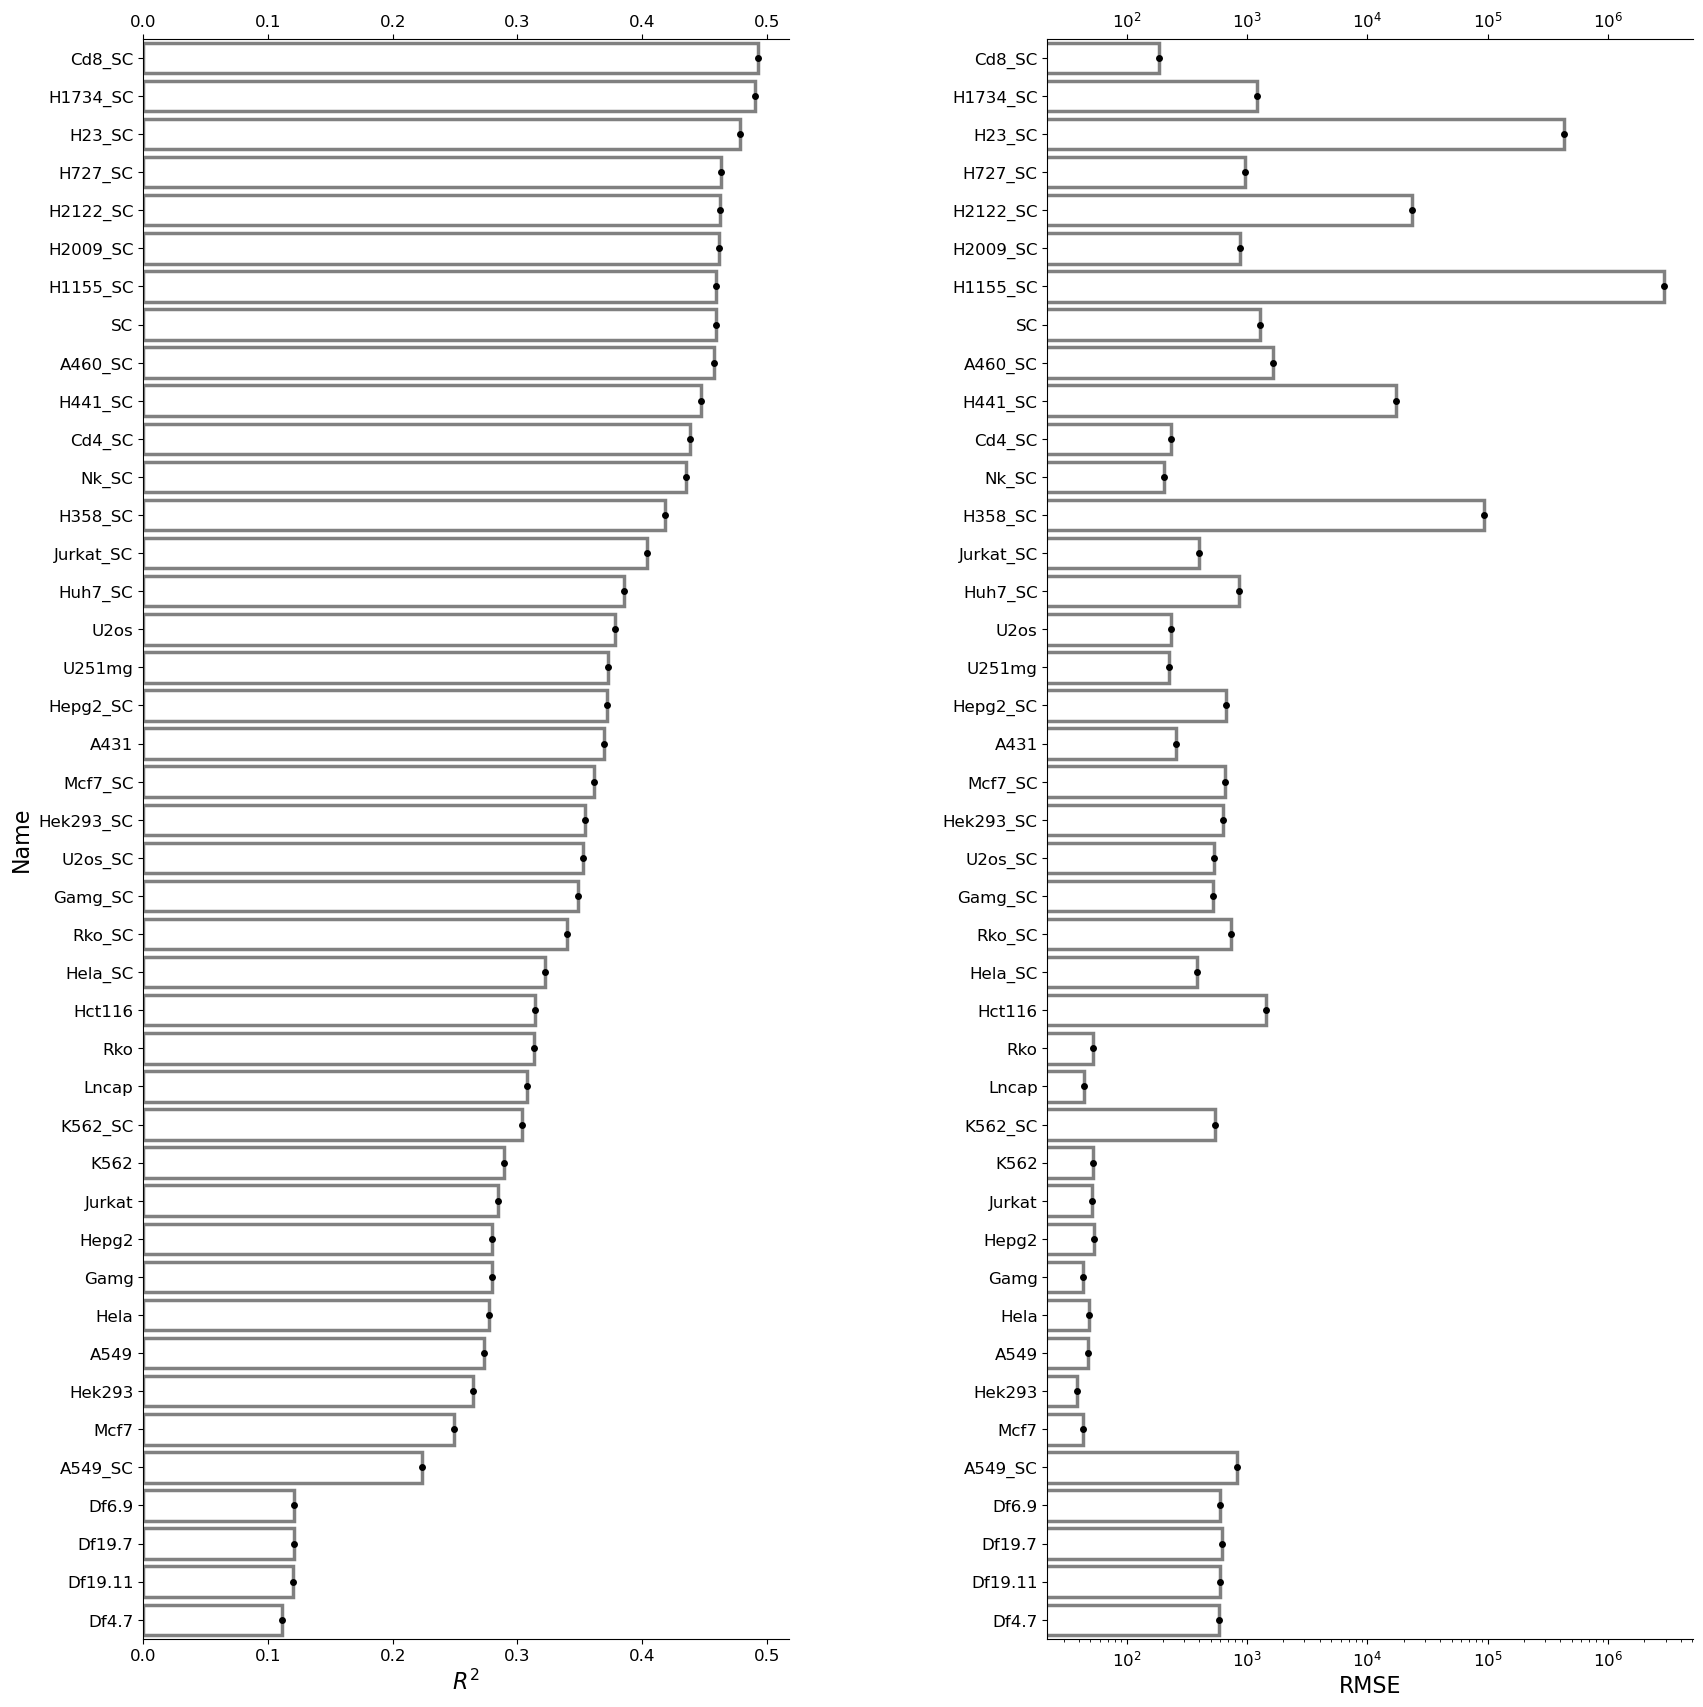

In [370]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
f, axs = plt.subplots(1,2, figsize=[20, 20])
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
axs[0].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
axs[1].tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)


#ax.spines['bottom'].set_color('white')
#ax.spines['top'].set_color('white') 
axs[0].spines['right'].set_color('white')
axs[1].spines['right'].set_color('white')
#ax.spines['left'].set_color('white')

df = df.loc[df["Tax_id"]!="CELL_LINE"]

order = df.loc[df["Type"]=="Median"].sort_values(by="R2_BoxCox", ascending=False)["Name"].unique()
df_tmp_median = df.loc[df["Type"]=="Median"]
df_tmp_median = df_tmp_median.assign(R2_BoxCox=df_tmp_median["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.barplot(data=df_tmp_median,x="R2_BoxCox", y="Name", ax=axs[0], order=order, linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )

df_tmp_experiment = df.loc[df["Type"]=="Experiment"]
df_tmp_experiment =df_tmp_experiment.assign(R2_BoxCox=df_tmp_experiment["R2_BoxCox"].map(lambda x: 0 if x < 0 else x))
sns.stripplot(data=df_tmp_experiment,x="R2_BoxCox", y="Name", ax=axs[0], order=order, color="k")


sns.barplot(data=df.loc[df["Type"]=="Median"],x="RMSE", y="Name", ax=axs[1], order=order , linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0) )
sns.stripplot(data=df.loc[df["Type"]=="Experiment"],x="RMSE", y="Name", ax=axs[1], order=order, color="k")

#axs[0].set_xlim([0,1])
axs[1].set_xscale("log")
axs[1].set_ylabel("")
axs[0].set_xlabel(r"$R^2$")
#f.suptitle(r"Model performance on Human tissue")
plt.savefig("../../result/2024-0829/Model_performance_Median_and_experiment_Human_cell_line.pdf", dpi=400)
plt.show()